# Customer Dataframe Preparation

In [1]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import statistics as stat
import seaborn as sns

In [6]:
# loading cleaned dataframe
df = pd.read_csv('datasets/cleaned_dataframe.csv', sep='\t', index_col=0)

In [7]:
df.head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
0,536365,2010-01-12 08:26:00,2.55,17850,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6
1,536365,2010-01-12 08:26:00,3.39,17850,United Kingdom,71053,WHITE METAL LANTERN,6
2,536365,2010-01-12 08:26:00,2.75,17850,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8
3,536365,2010-01-12 08:26:00,3.39,17850,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6
4,536365,2010-01-12 08:26:00,3.39,17850,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398767 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   BasketID         398767 non-null  object 
 1   BasketDate       398767 non-null  object 
 2   Sale             398767 non-null  float64
 3   CustomerID       398767 non-null  int64  
 4   CustomerCountry  398767 non-null  object 
 5   ProdID           398767 non-null  object 
 6   ProdDescr        398767 non-null  object 
 7   Qta              398767 non-null  int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 27.4+ MB


In [122]:
# Create customer dataframe
data = pd.core.frame.DataFrame({'CustomerID' : df['CustomerID'].unique()})
print("Number of unique customers: ", len(data))
data.head()

Number of unique customers:  4333


,CustomerID
0,17850
1,13047
2,12583
3,13748
4,15100


# Index creation for Customer Dataframe

In [88]:
unique_products = []     # number of unique products per customer
total_products = []      # number of total products per customer
total_prod_returned = [] # number of total products returned per customer
total_orders = []        # number of total orders per customer
total_sale = []          # total amount spent per customer
total_sale_wret = []     # total amount spent per customer (only positive shopping, not including returns)
min_prod_spent = []      # minimum amount spent in the observation period (by product) per customer
max_prod_spent = []      # maximum amount spent in the observation period (by product) per customer
mean_prod_sale = []      # mean amount spent in the observation period per customer

#Discount shouldn't be part of products bought nor returned 
for customer in tqdm(df['CustomerID'].unique(), total=len(data), desc="Iterating over customers"):
    # use set ?
    # dividing filters instead of conjuncting them is MUCH FASTER
    df_temp = df.loc[df['CustomerID'] == customer, ['ProdID']].drop_duplicates()
    unique_products.append(len(df_temp.loc[df_temp['ProdID'] != 'D']))
    
    
    # discount are counted in total orders
    df_temp = df.loc[df['CustomerID'] == customer, ['BasketID', 'Qta']]
    df_temp = df_temp.loc[df['Qta'] > 0, ['BasketID']].drop_duplicates()
    total_orders.append(len(df_temp))
    
    # discount values are useful in meanps and tswr
    # discount values are NOT useful in mps, since they would always be the min value
    # discount values are useful in ts but have to be avoided in tp (not a real product)
    df_aux = df.loc[df['CustomerID'] == customer, ['Qta', 'Sale','ProdID']]
    tp = tpr = ts = tswr = 0
    mps = []
    meanps = []
    for _, r in df_aux.iterrows():
        cost = r['Qta']*r['Sale']
        tp += r['Qta'] if r['ProdID'] != 'D' else 0
        ts += cost
        if r['Qta'] > 0 or r['ProdID'] == 'D':
            tswr += cost
            meanps.append(r['Sale'])
            if r['Qta'] > 0: # not DISCOUNT
                mps.append(cost)
        else:
            tpr -= r['Qta']
            
    total_products.append(tp)
    total_prod_returned.append(tpr)
    total_sale.append(ts)
    total_sale_wret.append(tswr)
    min_prod_spent.append(min(mps))
    max_prod_spent.append(max(mps))
    mean_prod_sale.append(stat.fmean(meanps))

In [7]:
# create auxiliary dictionary {order_stats_per_customer} for index creation (by order) per customer

order_stats_per_customer = {} # key = customerID, value = list(max_products_order, min, mean_accum, max_spent_order, min, mean_accum, mean_counter) 
mean_counter = 0
data_about_order = df[['BasketID','CustomerID']].drop_duplicates()

######################################################################################################################################
#what about discount? no sense reasoning about those records if calculating max/min qta/sale, but reasonable to add them in mean calc#
######################################################################################################################################

for _, r in tqdm(data_about_order.iterrows(), total=len(data_about_order), desc="Iterating over orders"):
    customer = r["CustomerID"]
    order = r["BasketID"]
    df_aux = df.loc[df['BasketID'] == order, ['Qta','Sale','ProdID', 'CustomerID']]
    df_aux = df_aux.loc[df['CustomerID'] == customer, ['Qta','Sale','ProdID']]
    temp_prod = 0
    temp_sale = 0 
    
    for _, int_r in df_aux.iterrows():
        temp_prod += int_r['Qta']
        temp_sale += int_r['Qta']*int_r['Sale']
        
    is_neg = False
    if temp_prod < 0 or temp_sale < 0:
        is_neg = True  
    
    if customer not in order_stats_per_customer:
        order_stats_per_customer[customer] = [math.inf, math.inf, 0, math.inf, math.inf, 0, 0]
        
    if not is_neg:
        if order_stats_per_customer[customer][0] == math.inf or order_stats_per_customer[customer][0] < temp_prod:
            order_stats_per_customer[customer][0] = temp_prod
        if order_stats_per_customer[customer][1] == math.inf or order_stats_per_customer[customer][1] > temp_prod:
            order_stats_per_customer[customer][1] = temp_prod
        if order_stats_per_customer[customer][3] == math.inf or order_stats_per_customer[customer][3] < temp_sale:
            order_stats_per_customer[customer][3] = temp_sale
        if order_stats_per_customer[customer][4] == math.inf or order_stats_per_customer[customer][4] > temp_sale:
            order_stats_per_customer[customer][4] = temp_sale
            
    order_stats_per_customer[customer][2] += temp_prod
    order_stats_per_customer[customer][5] += temp_sale
    order_stats_per_customer[customer][6] += 1

In [8]:
max_spent_order_wise = []      # maximum amount spent (by order) per customer
min_spent_order_wise = []      # minimum amount spent (by order) per customer
mean_spent_order_wise = []     # mean amount spent (by order) per customer
max_products_order_wise = []   # maximum number of products bought in a single shopping session per customer
min_products_order_wise = []   # minimum number of products bought in a single shopping session per customer
mean_products_order_wise = []  # mean number of products bought per shopping session per customer

for customer in tqdm(df['CustomerID'].unique(), total=len(data), desc="Iterating over customers"):
    max_products_order_wise.append(order_stats_per_customer[customer][0])
    min_products_order_wise.append(order_stats_per_customer[customer][1])
    mean_products_order_wise.append(order_stats_per_customer[customer][2] / order_stats_per_customer[customer][6])
    max_spent_order_wise.append(order_stats_per_customer[customer][3])
    min_spent_order_wise.append(order_stats_per_customer[customer][4])
    mean_spent_order_wise.append(order_stats_per_customer[customer][5] / order_stats_per_customer[customer][6])

We decided to also create temporal indexes

In [41]:
mean_order_month = [elem / 12 for elem in total_orders]  # mean amount of orders per month
mean_prod_month = [elem / 12 for elem in total_products] # mean amount of products bought per month
mean_sale_month = [elem / 12 for elem in total_sale]     # mean amount spent per month

month_with_most_orders = {}                              # month with most orders per customer
df['BasketDate'] = pd.to_datetime(df["BasketDate"]) 
months = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

for customer in tqdm(df['CustomerID'].unique(), total=len(df['CustomerID'].unique()), desc="Understanding month with most orders per customer"):
    orders_per_month = {1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[], 12:[]}
    df_aux = df.loc[df['CustomerID'] == customer,['BasketID','BasketDate']]
    for _,r in df_aux.iterrows():
        orders_per_month[r['BasketDate'].month].append(r['BasketID'])
    
    orders_per_month_count = {}
    max_val, max_key = -1, -1
    for key,value in orders_per_month.items():
        orders_per_month_count[key] = len(set(value))
    
    for key,value in orders_per_month_count.items():
        if value > max_val:
            max_val = value
            max_key = key
    
    month_with_most_orders[customer] = months[max_key]
    
    

We decided to also reason on more statistical indexes, opting for Shannon Entropy

In [10]:
#indicator on Shannon Entropy about sale*qta values on whole period of observation
entropy_saleqta = []

for customer in tqdm(df['CustomerID'].unique(), total=len(data), desc="Iterating over customers"):
    customer_entropy_counts = []
    
    df_aux = df.loc[df['CustomerID'] == customer, ['Sale', 'Qta']]
    for _, r in df_aux.iterrows():
        customer_entropy_counts.append(r['Qta']*r['Sale'])
    
    customer_entropy_prob = pd.core.frame.DataFrame({'cust_count': customer_entropy_counts}).value_counts(normalize=True)
    entropy_saleqta.append(stats.entropy(customer_entropy_prob, base = 2))

In [11]:
#indicator on Shannon Entropy about sale*qta values on whole period of observation (order based)
entropy_saleqta_order = []
for customer in tqdm(df['CustomerID'].unique(), total=len(data), desc="Iterating over customers"):
    
    basket_list = df[df['CustomerID'] == customer]['BasketID'].unique()
    customer_entropy_counts = []
    
    for basket in basket_list:
        df_aux = df[df['CustomerID'] == customer]
        df_aux = df_aux.loc[df_aux['BasketID'] == basket,['Sale','Qta']]
        accum = 0
        for _, r in df_aux.iterrows():
            accum += r['Qta']*r['Sale']
        customer_entropy_counts.append(accum)
    
    customer_entropy_prob = pd.core.frame.DataFrame({'cust_count': customer_entropy_counts}).value_counts(normalize=True)
    entropy_saleqta_order.append(stats.entropy(customer_entropy_prob, base = 2))

In [123]:
# TProd: the total number of items purchased by a customer during the period of observation.
data['TProd'] = total_products

# DProd: the number of distinct items bought by a customer in the period of observation.
data['DProd'] = unique_products

# MaxPO: the maximum number of items purchased by a customer during a shopping session
data['MaxPO'] = max_products_order_wise

# MinPO: the minimum number of items purchased by a customer during a shopping session
data['MinPO'] = min_products_order_wise

# MeanProdOrder: mean number of items purchased by a customer during a shopping session
data['MeanProdOrder'] = mean_products_order_wise

# TSale: total amount spent during the period of observation
data['TSale'] = total_sale

# TSaleWRet: total amount spent without negative quantity during the period of observation
data['TSaleWRet'] = total_sale_wret

# MinPSale: min amount spent for a product during the shopping session
data['MinPSale'] = min_prod_spent

# MaxPSale: max amount spent for a product during the shopping session
data['MaxPSale'] = max_prod_spent

# MeanSaleOrder: mean amount spent for each order during the period of observation
data['MeanSaleOrder'] = mean_spent_order_wise

# TRProd: number of returned products in the period of observation
data['TRProd'] = total_prod_returned

# MeanPSale: mean cost of the products in the orders in the period of observation
data['MeanPSale'] = mean_prod_sale

# TOrder: total number of orders made by customer
data['TOrder'] = total_orders

# OrderMonth
data['OrderMonth'] = mean_order_month

# ProdMonth
data['ProdMonth'] = mean_prod_month

# SaleMonth
data['SaleMonth'] = mean_sale_month

# SETSaleQta: Shannon Entropy Total Sale Qta: calculated on whole period of observation.
data['SETSaleQta'] = entropy_saleqta

# SESaleQtaOrder: Shannon Entropy Sale Qta Order wise: calculated on whole period of observation.
data['SESaleQtaOrder'] = entropy_saleqta_order

# MaxOrderMonth
data['MaxOrderMonth'] = month_with_most_orders.values()

In [124]:
data = data.round(3) # rounding values to avoid later machine dependent errors
data

,CustomerID,TProd,DProd,MaxPO,MinPO,MeanProdOrder,TSale,TSaleWRet,MinPSale,MaxPSale,MeanSaleOrder,TRProd,MeanPSale,TOrder,OrderMonth,ProdMonth,SaleMonth,SETSaleQta,SESaleQtaOrder,MaxOrderMonth
0,17850,1702,21,141,12,48.629,5317.89,5391.21,6.36,107.25,151.940,31,3.960,34,2.833,141.833,443.158,4.137,3.186,Feb
1,13047,1355,105,309,3,84.688,3089.10,3232.59,6.64,68.00,193.069,35,3.926,9,0.750,112.917,257.425,5.421,3.875,Jan
2,12583,4978,114,714,100,292.824,6629.34,6705.38,6.80,132.80,389.961,50,2.140,15,1.250,414.833,552.445,5.804,4.087,Aug
3,13748,439,24,208,8,87.800,948.25,948.25,9.36,204.00,189.650,0,3.996,5,0.417,36.583,79.021,4.080,2.322,May
4,15100,58,1,32,16,9.667,635.10,876.00,175.20,350.40,105.850,22,10.950,3,0.250,4.833,52.925,2.252,2.252,Jan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4328,13436,76,12,76,76,76.000,196.89,196.89,10.20,25.50,196.890,0,5.830,1,0.083,6.333,16.407,3.418,0.000,Aug
4329,15520,314,18,314,314,314.000,343.50,343.50,9.48,34.68,343.500,0,1.724,1,0.083,26.167,28.625,2.997,0.000,Aug
4330,13298,96,2,96,96,96.000,360.00,360.00,90.00,270.00,360.000,0,3.750,1,0.083,8.000,30.000,1.000,0.000,Aug
4331,14569,79,10,79,79,79.000,227.39,227.39,1.65,122.40,227.390,0,3.920,1,0.083,6.583,18.949,3.418,0.000,Aug


In [125]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4333 entries, 0 to 4332
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      4333 non-null   int64  
 1   TProd           4333 non-null   int64  
 2   DProd           4333 non-null   int64  
 3   MaxPO           4333 non-null   int64  
 4   MinPO           4333 non-null   int64  
 5   MeanProdOrder   4333 non-null   float64
 6   TSale           4333 non-null   float64
 7   TSaleWRet       4333 non-null   float64
 8   MinPSale        4333 non-null   float64
 9   MaxPSale        4333 non-null   float64
 10  MeanSaleOrder   4333 non-null   float64
 11  TRProd          4333 non-null   int64  
 12  MeanPSale       4333 non-null   float64
 13  TOrder          4333 non-null   int64  
 14  OrderMonth      4333 non-null   float64
 15  ProdMonth       4333 non-null   float64
 16  SaleMonth       4333 non-null   float64
 17  SETSaleQta      4333 non-null   f

## Correlation analysis 

First of all we define CustomerID as index of our customer-driven dataframe

In [126]:
data.set_index("CustomerID", inplace = True)

Plot correlation matrix to individuate attributes we can possibly drop

Text(0.5, 1.0, 'Correlation matrix')

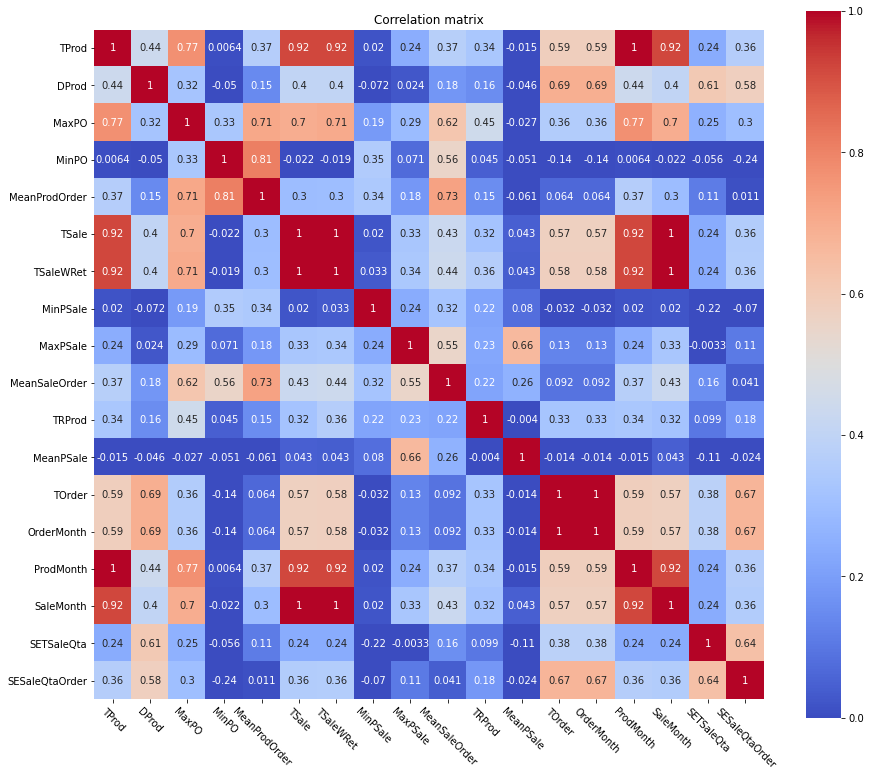

In [127]:
f, ax = plt.subplots(figsize=(15, 13))
correlation = data.corr()
sns.heatmap(correlation, cmap="coolwarm", vmin=0, vmax=1, annot=True, mask=np.zeros_like(correlation, dtype=np.bool), square=True, ax=ax, edgecolor='black')
plt.xticks(rotation=315)
plt.title("Correlation matrix")

Check which attributes go above a certain correlation threshold

In [133]:
high_corr = []
threshold = 0.75
list_corr = list(correlation.to_numpy())
ext_ind = 0
for i in list_corr:
    int_ind = 0
    for j in i:
        if j > threshold and int_ind != ext_ind:
            high_corr.append(int_ind)
        int_ind += 1
    ext_ind += 1

print("Attributes above threshold of",threshold,"are:\n",list(data.columns[list(set(high_corr))]))

Attributes above threshold of 0.75 are:
 ['TProd', 'MaxPO', 'MinPO', 'MeanProdOrder', 'TSale', 'TSaleWRet', 'TOrder', 'OrderMonth', 'ProdMonth', 'SaleMonth']


We decide to keep TProd, TSale, TOrder, and MeanProdOrder because they are either interesting for later analysis or robust enough for clustering.<br>
Remaining are **DROPPED**

In [134]:
data.drop(columns = ['MinPO', 'MaxPO', 'OrderMonth', 'ProdMonth', 'SaleMonth', 'TSaleWRet'], inplace=True, errors='ignore')

Plot correlation matrix again and recheck correlation values

Text(0.5, 1.0, 'Correlation matrix')

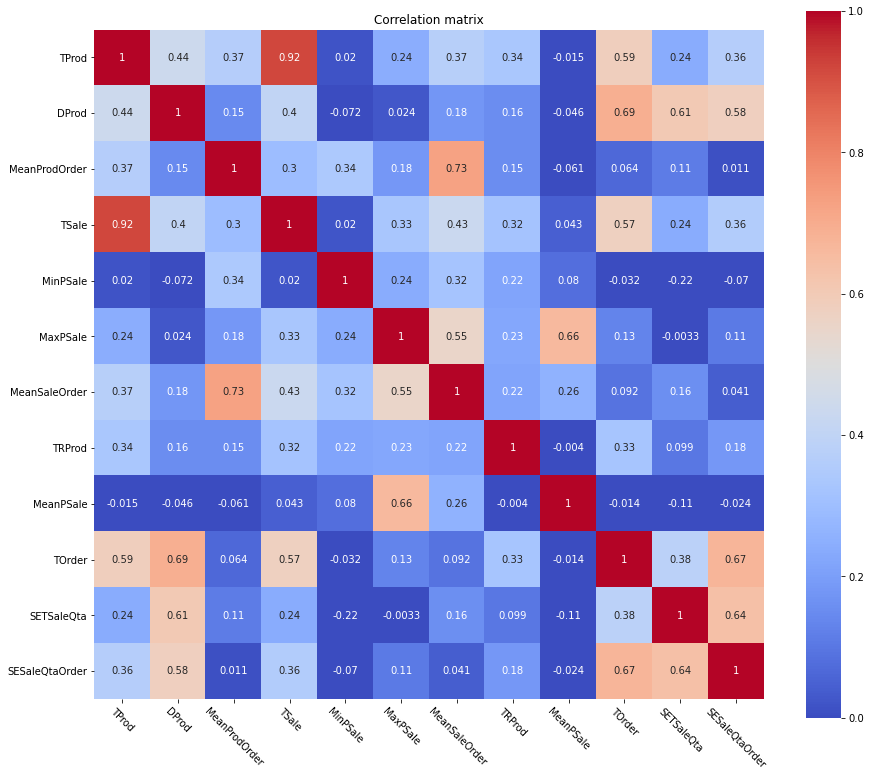

In [135]:
f, ax = plt.subplots(figsize=(15, 13))
correlation = data.corr()
sns.heatmap(correlation, cmap="coolwarm", vmin=0, vmax=1, annot=True, mask=np.zeros_like(correlation, dtype=np.bool), square=True, ax=ax, edgecolor='black')
plt.xticks(rotation=315)
plt.title("Correlation matrix")

In [137]:
high_corr = []
list_corr = list(correlation.to_numpy())
ext_ind = 0
for i in list_corr:
    int_ind = 0
    for j in i:
        if j > threshold and int_ind != ext_ind:
            high_corr.append(int_ind)
        int_ind += 1
    ext_ind += 1
    
print("Attributes above threshold of",threshold,"are:\n",list(data.columns[list(set(high_corr))]))

Attributes above threshold of 0.75 are:
 ['TProd', 'TSale']


# Taking a peak at our data..

In [159]:
data.describe()[['TProd', 'MeanProdOrder', 'MeanSaleOrder', 'MeanPSale']]

,TProd,MeanProdOrder,MeanSaleOrder,MeanPSale
count,4333.000000,4333.000000,4333.000000,4333.000000
mean,1129.535657,201.104614,327.882896,3.492819
std,4692.695935,274.590134,395.336014,8.997404
min,0.000000,0.000000,-0.000000,0.122000
25%,157.000000,80.500000,155.050000,2.160000
50%,370.000000,140.167000,241.900000,2.834000
75%,971.000000,237.750000,371.560000,3.712000
max,196556.000000,7824.000000,9904.875000,434.650000


Looking at the months where customers have most orders

<AxesSubplot:>

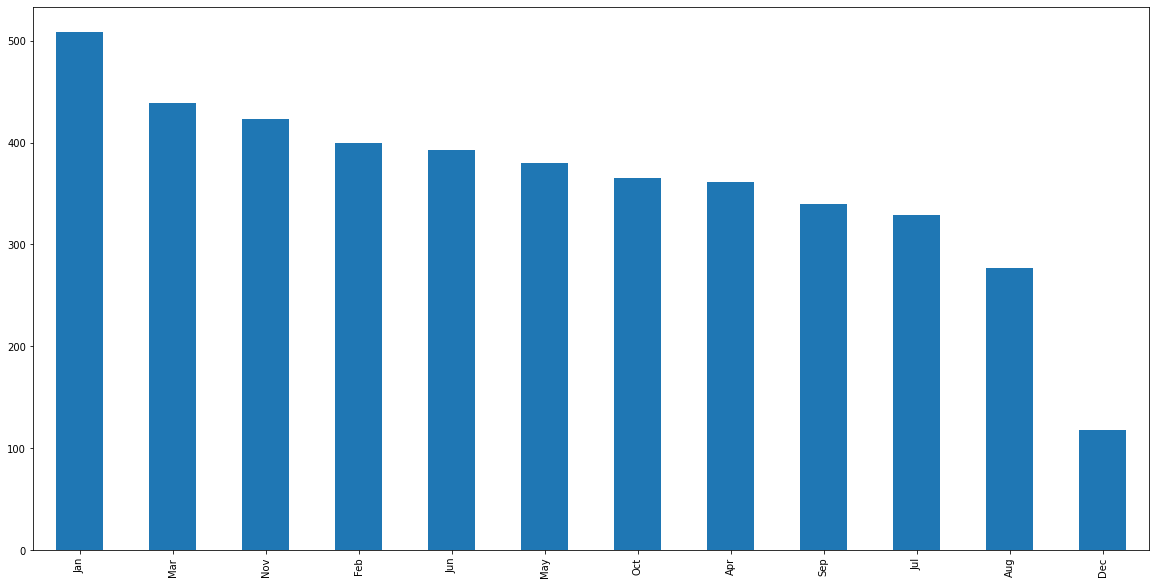

In [147]:
data['MaxOrderMonth'].value_counts().plot(kind='bar', figsize=(20,10))

Looking at the variabiliy of Sales and Qta (in different ways) using Shannon Entropy

<AxesSubplot:>

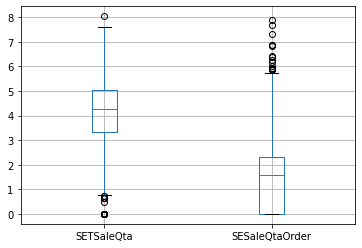

In [162]:
data.boxplot(column=['SETSaleQta','SESaleQtaOrder'])

**Saving customer-driven dataframe**

In [163]:
path = 'customer_dataframe.csv'
data.to_csv(path, sep='\t')
print(f"Customer dataframe saved to '{path}'")

Customer dataframe saved to 'customer_dataframe.csv'
